<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/univariate_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


<br>

## 2. Split Data
Training set: 60% | Validation set: 20% | Testing set: 20%

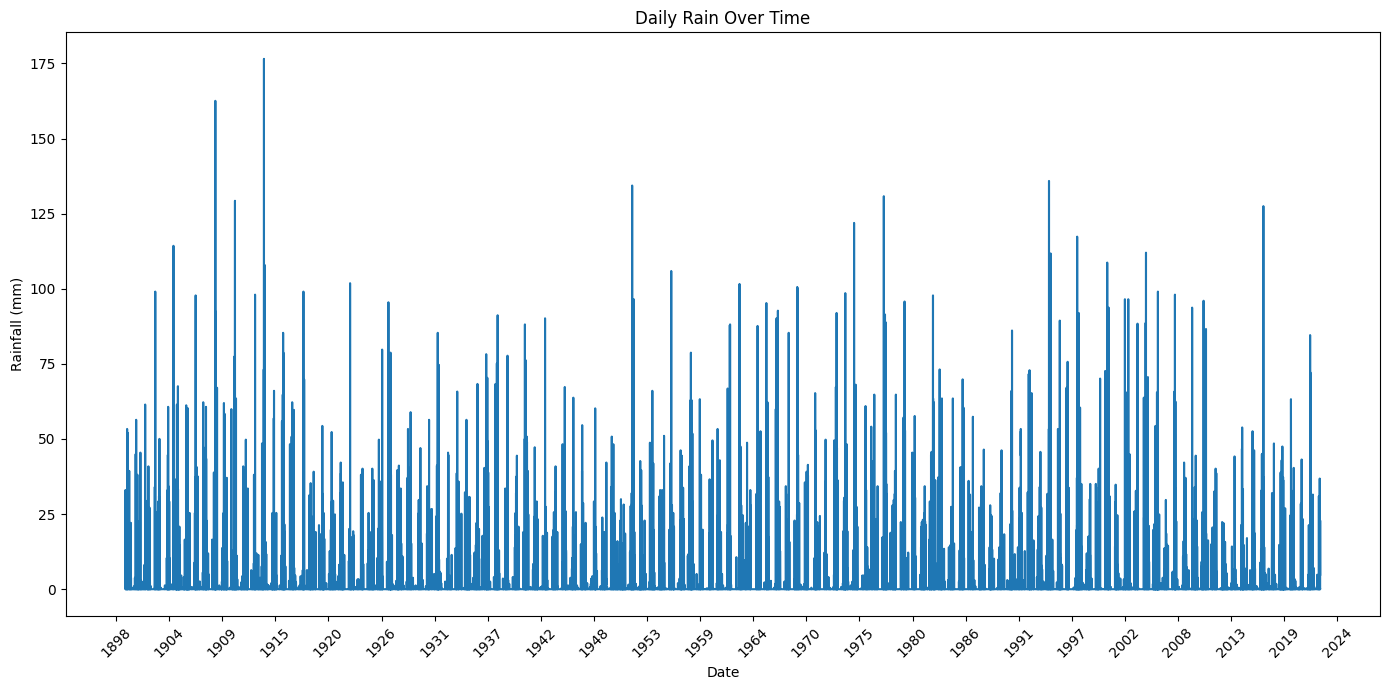

In [ ]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(df.index,df['daily rain'],label = 'Daily Rain')
plt.title('Daily Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train = df[["daily rain"]].iloc[:train_end]
validation = df[["daily rain"]].iloc[train_end:validation_end]
test = df[["daily rain"]].iloc[validation_end:]

<br>

## 3. Standardize Data and create series
MinMaxScaler

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
print(type(train_scaled))
train_scaled

<class 'numpy.ndarray'>


array([[0.01726619],
       [0.01151079],
       [0.18705036],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [ ]:
T = 90 # Consider seasonality

# Prepend the last T-1 observations from the training set to the validation features
prepend_features_to_validation = train_features.iloc[-(T-1):]
validation_features = pd.concat([prepend_features_to_validation, validation_features], axis=0)

# Similarly, prepend the last T-1 observations from the validation set (including the part that was just prepended) to the test features
prepend_features_to_test = validation_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features_to_test, test_features], axis=0)

# Output the shapes of the datasets to check everything is as expected
train_features.shape, train_rain.shape, validation_features.shape, validation_rain.shape, test_features.shape, test_rain.shape